<a href="https://colab.research.google.com/github/akshitha-nagaraj/dvs-gestures/blob/main/DVSGesture_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="300">](https://github.com/jeshraghian/snntorch/)
[<img src='https://github.com/neuromorphs/tonic/blob/develop/docs/_static/tonic-logo-white.png?raw=true' width="200">](https://github.com/neuromorphs/tonic/)


# Training the DVSGesture Dataset with SNNs

#### By Akshitha Nagaraj(aknagara@ucsc.edu), Shashwat Dwivedi (sdwived2@ucsc.edu), Selam Mitike (smitike@ucsc.edu), Wei feng Tan (wtan40@ucsc.edu)

#### Based off of Tutorial 7 By Gregor Lenz (lenzgregor.com) and Jason K. Eshraghian (www.ncg.ucsc.edu)

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/examples/tutorial_7_neuromorphic_datasets.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)

The snnTorch tutorial series is based on the following paper. If you find these resources or code useful in your work, please consider citing the following source:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>

# Introduction


Before we start, ensure you are connected to a GPU runtime. Spiking neural networks can be computationally intensive, and using a GPU will significantly speed up the training process.

If running in Google Colab:
* You may connect to GPU by checking `Runtime` > `Change runtime type` > `Hardware accelerator: GPU`
* Next, install the latest PyPi distribution of snnTorch and Tonic by clicking into the following cell and pressing `Shift+Enter`.

In [ ]:
!pip install tonic --quiet
!pip install snntorch --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 455.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 36.1 MB/s eta 0:00:00


In [ ]:
# imports
import tonic
import matplotlib.pyplot as plt
import tonic.transforms as transforms

import torch
import torchvision

import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
import torch.nn as nn

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# 1. Using Tonic to Load Neuromorphic Datasets

In this code snippet, we:

Import the tonic library and its transforms module, which provides tools for handling and transforming neuromorphic datasets. Import several modules from snntorch that are necessary for building, training, and visualizing spiking neural networks. Import PyTorch libraries (torch, torchvision, torch.nn, and torch.utils.data) for building and training our model. Import DiskCachedDataset and MemoryCachedDataset from tonic to manage dataset caching. Set the device variable to use a GPU if available. If a GPU is not available, it falls back to Apple's Metal Performance Shaders (MPS) if on a compatible Apple device, or to the CPU. Note: If at any point an HTTP 403 (Forbidden) error pops up, simply disconnect from and reconnect to the runtime, then rerun the cells. This is more likely to happen if the session has been running for a long time, as files can get corrupted or permissions can expire.

Now that our environment is set up, we can proceed to load and preprocess the dataset.

Loading the Dataset: We use the tonic.datasets.DVSGesture function to load the DVSGesture dataset. The save_to parameter specifies the directory where the dataset will be saved, and the train parameter indicates that we are loading the training set.

Retrieving a Sample: We retrieve the first sample from the dataset using dataset[0]. This sample includes the events and the corresponding target label. Events in the dataset represent changes detected by the DVS camera, such as changes in light intensity, and are recorded with precise timestamps.

Printing Events: Finally, we print the events to get a feel for the data. Each event consists of a timestamp, the x and y coordinates of the pixel where the event occurred, and a polarity indicating whether the change was an increase or decrease in light intensity.

Note: If at any point an HTTP 403 (Forbidden) error pops up, simply disconnect from and reconnect to the runtime, then rerun the cells. This is more likely to happen if the session has been running for a long time, as files can get corrupted or permissions can expire.

By exploring the events, we can better understand the nature of the data we're working with. Neuromorphic datasets like DVSGesture provide rich temporal information that is well-suited for processing with spiking neural networks. In the next sections, we'll dive deeper into preprocessing the data and building our SNN model.

In [ ]:
dataset = tonic.datasets.DVSGesture(save_to='./data', train=True)
events, label = dataset[0]

# Dataset size
print("Dataset contains ", len(dataset), " samples.")

# Number of events in the first sample
print("There are ", len(events), " events in the first sample.")

# (x-pos, y-pos, polarity, timestamp)
print("A single event: ", events[0])

  0%|          | 0/2443675558 [00:00<?, ?it/s]

Extracting ./data/DVSGesture/ibmGestureTrain.tar.gz to ./data/DVSGesture
Dataset contains  1077  samples.
There are  787770  events in the first sample.
A single event:  (119, 113, False, 6)


Each row corresponds to a single event, which consists of four parameters: (*x-coordinate, y-coordinate, timestamp, polarity*).

* x & y co-ordinates correspond to an address in a $34 \times 34$ grid.

* The timestamp of the event is recorded in microseconds.

* The polarity refers to whether an on-spike (+1) or an off-spike (-1) occured; i.e., an increase in brightness or a decrease in brightness.

If we were to accumulate those events over time and plot the bins as images, it looks like this:

<ipython-input-4-8a990e6d110b>:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  tonic.utils.plot_event_grid(events)


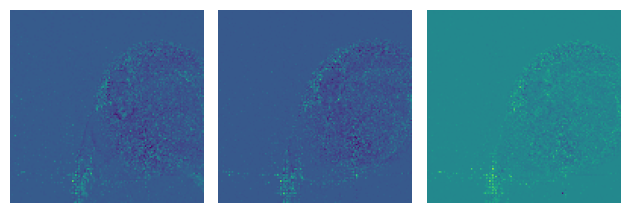

In [ ]:
tonic.utils.plot_event_grid(events)

## 1.1 Transformations

**Preprocessing Neuromorphic Data**

In this section, we'll explore how to preprocess neuromorphic data using Tonic transforms. Specifically, we'll apply denoising and clustering transformations to the DVSGesture dataset to prepare it for training our spiking neural network.

Before we proceed, let's understand the transformations we'll be applying:

**Denoise** **Transformation**:

 This transformation removes isolated, one-off events from the data. In our case, it will remove outlier events with inactive surrounding pixels for 10 milliseconds.

**ToFrame Transformation**:

This transformation bins events into clusters of frames. Each cluster will contain 25 frames, effectively clustering the events together for more efficient preprocessing.


Let's define and apply the transformations to the DVSGesture dataset:

In [ ]:
sensor_size = tonic.datasets.DVSGesture.sensor_size

# Denoise removes isolated, one-off events
# time_window

# Denoise transform removes outlier events with inactive surrounding pixels for 10ms
denoise_transform = transforms.Denoise(filter_time=10000)

# ToFrame transform bins events into 25 clusters of frames
frame_transform = transforms.ToFrame(sensor_size=sensor_size, n_time_bins=25)

# Chain the transforms
all_transform = transforms.Compose([denoise_transform, frame_transform])


trainset = tonic.datasets.DVSGesture(save_to='./tmp/data', transform=all_transform, train=True)
testset = tonic.datasets.DVSGesture(save_to='./tmp/data', transform=all_transform, train=False)

  0%|          | 0/2443675558 [00:00<?, ?it/s]

Extracting ./tmp/data/DVSGesture/ibmGestureTrain.tar.gz to ./tmp/data/DVSGesture


  0%|          | 0/691455012 [00:00<?, ?it/s]

Extracting ./tmp/data/DVSGesture/ibmGestureTest.tar.gz to ./tmp/data/DVSGesture


**Explanation**

Defining Transformations: We define the denoise and to-frame transformations with specific parameters. The denoise transformation removes isolated events with inactive surrounding pixels for 10 milliseconds, while the to-frame transformation bins events into 25 clusters of frames.

**Chaining Transformations:**

We chain the transformations together using transforms.Compose, ensuring that both transformations are applied sequentially to the events.

**Applying Transformations:**

We apply the transformations to both the training and testing sets of the DVSGesture dataset. This preprocesses the data, making it suitable for training our spiking neural network.

## 1.2 Fast DataLoading

## Optimizing Data Loading with Disk Caching and Batching

To efficiently train our spiking neural network, we need to ensure that data loading is optimized. This involves using disk caching and batching, which significantly reduce loading times and improve processing efficiency.

### Disk Caching

Disk caching involves storing the transformed dataset on the disk. This means that once the data is loaded and transformed, it is written to the disk. Subsequent reads can quickly access this cached data, reducing the time required to load data during training.

### Batching

Batching groups multiple samples together into a single batch, which allows for more efficient processing. Instead of processing each sample individually, the network processes an entire batch at once, leveraging parallelism and reducing the overhead of data loading.

In [ ]:
from torch.utils.data import DataLoader
from tonic import DiskCachedDataset

cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/dvsgesture/train')
cached_testset = DiskCachedDataset(testset, cache_path='./cache/dvsgesture/test')

trainloader = DataLoader(cached_trainset, batch_size=64, shuffle=True, drop_last=True, collate_fn=tonic.collation.PadTensors(batch_first=False))
testloader = DataLoader(cached_testset, batch_size=32, shuffle=True, drop_last=True, collate_fn=tonic.collation.PadTensors(batch_first=False))

### Explanation

1. **Disk Caching**:
   - `DiskCachedDataset(trainset, cache_path='./cache/dvsgesture/train')`: This caches the transformed training set to the specified path on the disk. Similarly, we cache the testing set.
   - Disk caching reduces loading times as data is read from the local disk cache instead of being transformed on-the-fly from the original dataset.

2. **Batching**:
   - `DataLoader(cached_trainset, batch_size=64, shuffle=True, drop_last=True, collate_fn=tonic.collation.PadTensors(batch_first=False))`: This creates a dataloader for the cached training set.
   - `batch_size=64`: Specifies that each batch will contain 64 samples.
   - `shuffle=True`: Shuffles the dataset at the beginning of each epoch to ensure that the model does not learn any unintended order from the data.
   - `drop_last=True`: Drops the last incomplete batch if the dataset size is not divisible by the batch size.

3. **Padding with `PadTensors`**:
   - `collate_fn=tonic.collation.PadTensors(batch_first=False)`: Uses the `PadTensors` collation function from Tonic to pad shorter recordings.
   - Neuromorphic event recordings can have different lengths. Padding ensures that all samples in a batch have the same dimensions, making them easier and faster to process.
   - `batch_first=False`: Specifies the format of the batched tensors, which can be important depending on the specific model and framework used.

In [ ]:
def load_sample_batched():
    events, target = next(iter(trainloader))


**Function Definition**:

The function load_sample_batched is defined to load a sample batch from the trainloader.

**Fetching a Batch:**

events, target = next(iter(trainloader)): This line uses Python's iter and next functions to fetch the next batch from the dataloader.
iter(trainloader): Converts the trainloader into an iterator.
next(iter(trainloader)): Retrieves the first batch of events and their corresponding targets from the iterator.
Purpose
Verification: By loading a sample batch, we can verify that the data transformations (denoising, clustering, padding) and optimizations (disk caching, batching) are applied correctly.
Inspection: It allows us to inspect the shape and content of the batched data, ensuring that the dataloader is functioning as expected.
Debugging: This step is useful for debugging any issues related to data preprocessing and loading before proceeding to model training.
By implementing and using this function, we ensure that our data is ready and correctly formatted for training our spiking neural network. In the next section, we will measure the loading times to confirm the efficiency of our optimizations and further prepare for model training.







# 2. Training our network using frames created from events

## 2.1 Defining our network
We will use snnTorch + PyTorch to construct a CSNN, just as in the previous tutorial. The convolutional network architecture to be used is: 12C5-MP2-32C5-MP2-800FC10

- 12C5 is a 5$\times$5 convolutional kernel with 12 filters
- MP2 is a 2$\times$2 max-pooling function
- 800FC10 is a fully-connected layer that maps 800 neurons to 10 outputs

In [ ]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn

To build and train our spiking neural network (SNN), we will use the snntorch library, which provides tools and functionalities tailored for SNNs. Below, we'll explain the various imports and their roles in setting up and training the SNN.



In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5

#  Initialize Network
net = nn.Sequential(nn.Conv2d(2, 12, 5),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2),
                    nn.Conv2d(12, 32, 5),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2),
                    nn.Flatten(),
                    nn.Linear(32*5*5, 11),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)


**torch.device**

This function specifies the device on which tensors will be allocated.
"cuda": If a CUDA-enabled GPU is available, this option ensures computations are performed on the GPU.
"cpu": If no GPU is available, computations will be performed on the CPU.

**spike_grad**

We use a surrogate gradient function, fast_sigmoid, with a slope of 25. Surrogate gradients approximate the gradient of non-differentiable spike functions during backpropagation, enabling effective training of SNNs.
beta: This parameter is used in the leaky integrate-and-fire neuron model. It determines the membrane potential decay rate.

**nn.Sequential**

Constructs a sequential container where modules are added in the order they are defined.

**nn.Conv2d(2, 12, 5)**

A 2D convolutional layer with 2 input channels, 12 output channels, and a kernel size of 5.

**snn.Leaky**

Implements a leaky integrate-and-fire neuron layer with the specified beta and spike_grad. The init_hidden=True parameter initializes the hidden state for the neurons.

**nn.MaxPool2d(2)**

A max-pooling layer with a kernel size of 2, which reduces the spatial dimensions of the input.

**nn.Conv2d(12, 32, 5)**

Another 2D convolutional layer with 12 input channels, 32 output channels, and a kernel size of 5.
nn.Flatten(): Flattens the input tensor to prepare it for the fully connected layer.

**nn.Linear(3255, 11)**

A fully connected (linear) layer with 3255 input features and 11 output features, corresponding to the number of classes in the DVSGesture dataset.

**snn.Leaky:**

The final leaky integrate-and-fire neuron layer with init_hidden=True and output=True, indicating that this layer will produce the final output spikes.



By configuring the device, defining neuron parameters, and initializing the network architecture, we set up our spiking neural network for training. This network combines convolutional layers, max-pooling layers, and leaky integrate-and-fire neurons to process the neuromorphic data and produce spike-based outputs.

In the next section, we will define the training loop and evaluate the model's performance on the DVSGesture dataset.



In [ ]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.conv1 = nn.Conv2d(2, 12, 5)
        self.lif1 = snn.Leaky(beta=beta)
        self.conv2 = nn.Conv2d(12, 32, 5)
        self.lif2 = snn.Leaky(beta=beta)
        self.fc1 = nn.Linear(800, 11)
        self.lif3 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        mem_rec = []
        spk_rec = []

        for step in range(num_steps):

          cur1 = F.max_pool2d(self.conv1(x[step]), 2)
          spk1, mem1 = self.lif1(cur1, mem1)

          cur2 = F.max_pool2d(self.conv2(spk1), 2)
          spk2, mem2 = self.lif2(cur2, mem2)

          cur3 = self.fc1(spk2.flatten(1)) # batch x ....
          spk3, mem3 = self.lif3(cur3, mem3)

          spk_rec.append(spk3)
          mem_rec.append(mem3)

        return spk3, mem3

## Defining the Network Class

In this section, we will define a custom network class for our spiking neural network (SNN). This class will use PyTorch's `nn.Module` as a base class and will include layers and forward pass logic specifically designed for processing neuromorphic data.

### Network Class Definition

We define a custom network class, `Net`, which will contain convolutional layers, leaky integrate-and-fire (LIF) neuron layers, and a fully connected layer.


### Explanation

1. **Class Definition**:
    - `class Net(nn.Module)`: Defines a custom network class that inherits from `nn.Module`.

2. **Initialization**:
    - `def __init__(self)`: The constructor method initializes the layers of the network.
    - `super().__init__()`: Calls the constructor of the base class `nn.Module`.

3. **Layers**:
    - `self.conv1 = nn.Conv2d(2, 12, 5)`: A 2D convolutional layer with 2 input channels, 12 output channels, and a kernel size of 5.
    - `self.lif1 = snn.Leaky(beta=beta)`: A leaky integrate-and-fire (LIF) neuron layer with the specified `beta` parameter.
    - `self.conv2 = nn.Conv2d(12, 32, 5)`: Another 2D convolutional layer with 12 input channels and 32 output channels.
    - `self.lif2 = snn.Leaky(beta=beta)`: Another LIF neuron layer.
    - `self.fc1 = nn.Linear(800, 11)`: A fully connected layer with 800 input features and 11 output features.
    - `self.lif3 = snn.Leaky(beta=beta)`: Another LIF neuron layer for the output.

4. **Forward Pass**:
    - `def forward(self, x)`: Defines the forward pass logic for the network.
    - `mem1 = self.lif1.init_leaky()`: Initializes the hidden state for the first LIF layer.
    - `mem2 = self.lif2.init_leaky()`: Initializes the hidden state for the second LIF layer.
    - `mem3 = self.lif3.init_leaky()`: Initializes the hidden state for the third LIF layer.
    - `mem_rec = []`: List to record membrane potentials.
    - `spk_rec = []`: List to record spike outputs.
    - `for step in range(num_steps)`: Iterates over the time steps of the input data.
        - `cur1 = F.max_pool2d(self.conv1(x[step]), 2)`: Applies the first convolutional layer followed by max pooling.
        - `spk1, mem1 = self.lif1(cur1, mem1)`: Applies the first LIF neuron layer.
        - `cur2 = F.max_pool2d(self.conv2(spk1), 2)`: Applies the second convolutional layer followed by max pooling.
        - `spk2, mem2 = self.lif2(cur2, mem2)`: Applies the second LIF neuron layer.
        - `cur3 = self.fc1(spk2.flatten(1))`: Applies the fully connected layer to the flattened output of the second LIF layer.
        - `spk3, mem3 = self.lif3(cur3, mem3)`: Applies the third LIF neuron layer.
        - `spk_rec.append(spk3)`: Records the spike output of the third LIF layer.
        - `mem_rec.append(mem3)`: Records the membrane potential of the third LIF layer.
    - `return spk3, mem3`: Returns the final spike output and membrane potential.

### Summary

By defining the `Net` class, we encapsulate the network architecture and forward pass logic in a single, reusable component. This class combines convolutional layers, LIF neuron layers, and a fully connected layer to process the neuromorphic data and produce spike-based outputs. In the next section, we will define the training loop and evaluate the model's performance on the DVSGesture dataset.

In [ ]:
# this time, we won't return membrane as we don't need it

def forward_pass(net, data):
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(data.size(0)):  # data.size(0) = number of time steps
      spk_out, mem_out = net(data[step])
      spk_rec.append(spk_out)

  return torch.stack(spk_rec)

## Implementing the Forward Pass Function

In this section, we'll implement a function to perform the forward pass through our spiking neural network (SNN). This function will process input data through the network and record the spike outputs at each time step.

### Forward Pass Function

We define a function `forward_pass` that takes the network and the input data as arguments. The function processes the data through the network and returns the spike outputs.



### Explanation

1. **Function Definition**:
   - `def forward_pass(net, data)`: Defines the `forward_pass` function that takes the network (`net`) and input data (`data`) as arguments.

2. **Recording Spike Outputs**:
   - `spk_rec = []`: Initializes an empty list to record spike outputs at each time step.

3. **Resetting Hidden States**:
   - `utils.reset(net)`: Resets the hidden states for all leaky integrate-and-fire (LIF) neurons in the network. This ensures that the network starts with a clean state for each new input sequence.

4. **Iterating Over Time Steps**:
   - `for step in range(data.size(0))`: Iterates over each time step in the input data.
     - `data.size(0)`: The number of time steps in the input data.

5. **Processing Each Time Step**:
   - `spk_out, mem_out = net(data[step])`: Processes the data at the current time step through the

## 2.2 Training

In the previous tutorial, Cross Entropy Loss was applied to the total spike count to maximize the number of spikes from the correct class.

Another option from the `snn.functional` module is to specify the target number of spikes from correct and incorrect classes. The approach below uses the *Mean Square Error Spike Count Loss*, which aims to elicit spikes from the correct class 80\% of the time, and 20\% of the time from incorrect classes. Encouraging incorrect neurons to fire could be motivated to avoid dead neurons.

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.002, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

Training neuromorphic data is expensive as it requires sequentially iterating through many time steps (approximately 300 time steps in the DVSGesture dataset). The following simulation will take some time, so we will just stick to training with 20 epochs. Feel free to change `num_epochs` if you have more time to kill. As we are printing results at each iteration, the results will be quite noisy and will also take some time before we start to see any sort of improvement.

In our own experiments, after 20 epochs, we managed to crack ~80% accuracy.

In [ ]:
num_epochs = 20

loss_hist = []
acc_hist = []

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):
        # Downsampling image from (128 x 128) to (32 x 32)
        data = nn.functional.interpolate(data, size=(2, 32, 32))
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec = forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")


Epoch 0, Iteration 0 
Train Loss: 2.36
Accuracy: 4.69%

Epoch 0, Iteration 1 
Train Loss: 2.36
Accuracy: 7.81%

Epoch 0, Iteration 2 
Train Loss: 2.22
Accuracy: 10.94%

Epoch 0, Iteration 3 
Train Loss: 1.82
Accuracy: 17.19%

Epoch 0, Iteration 4 
Train Loss: 1.58
Accuracy: 12.50%

Epoch 0, Iteration 5 
Train Loss: 1.32
Accuracy: 26.56%

Epoch 0, Iteration 6 
Train Loss: 1.61
Accuracy: 34.38%

Epoch 0, Iteration 7 
Train Loss: 1.49
Accuracy: 46.88%

Epoch 0, Iteration 8 
Train Loss: 1.56
Accuracy: 31.25%

Epoch 0, Iteration 9 
Train Loss: 1.41
Accuracy: 34.38%

Epoch 0, Iteration 10 
Train Loss: 1.33
Accuracy: 32.81%

Epoch 0, Iteration 11 
Train Loss: 1.20
Accuracy: 45.31%

Epoch 0, Iteration 12 
Train Loss: 1.25
Accuracy: 37.50%

Epoch 0, Iteration 13 
Train Loss: 1.19
Accuracy: 28.12%

Epoch 0, Iteration 14 
Train Loss: 1.18
Accuracy: 48.44%

Epoch 0, Iteration 15 
Train Loss: 1.31
Accuracy: 31.25%

Epoch 1, Iteration 0 
Train Loss: 1.13
Accuracy: 43.75%

Epoch 1, Iteration 1 
Train

# 3. Results
## 3.1 Plot Test Accuracy

NameError: name 'acc_hist' is not defined

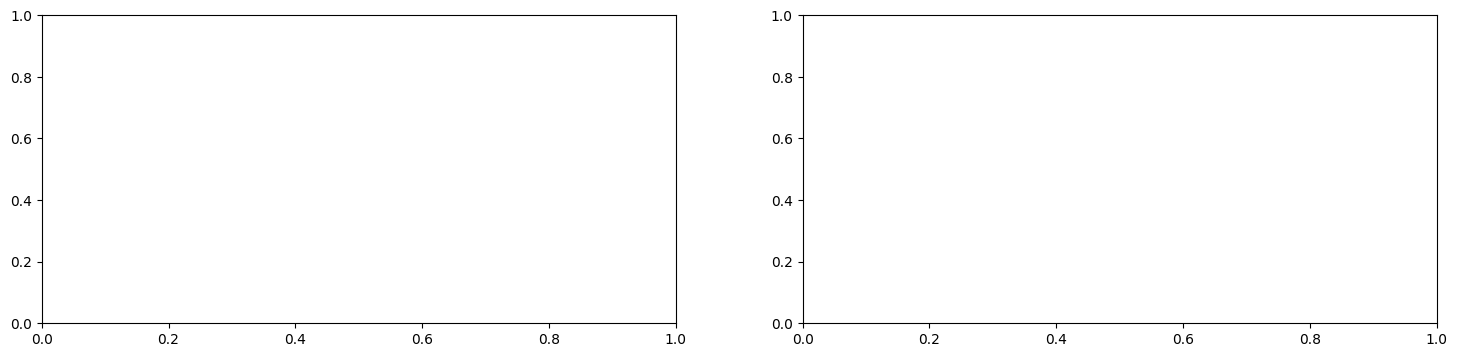

In [ ]:
import matplotlib.pyplot as plt

# train accuracy over epochs
fig = plt.figure(facecolor="w")
plt.plot(epoch, acc_hist, marker='o', linestyle='-', color='b')
plt.title("Train Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# loss over epochs
fig = plt.figure(facecolor="w")
plt.plot(epoch, loss_hist, marker='o', linestyle='-', color='r')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Visualizing Training Metrics

In this section, we'll visualize the training accuracy and loss history to monitor the performance of our spiking neural network (SNN) during training. We'll use Matplotlib to create the plots.

### Visualization Code

The following code creates a figure with two subplots: one for the training accuracy and one for the training loss.

### Explanation

1. **Importing Matplotlib**:
   - `import matplotlib.pyplot as plt`: Imports the Matplotlib library for plotting.

2. **Plotting Train Accuracy**:
- `fig = plt.figure(facecolor="w")`: Creates a new figure with a white background.
   - `plt.plot(epochs, acc_hist, marker='o', linestyle='-', color='b')`: Plots the training accuracy history stored in the acc_hist list. Each point is marked with a dot ('o'), and the points are connected with a blue line ('b').
   - `plt.title("Train Accuracy Over Epochs")`: Sets the title of the plot.
   - `plt.xlable("Epoch")`: Sets the label for the x-axis of the plot.
   - `plt.ylable("Accuracy")`: Sets the label for the y-axis of the plot.

3. **Plotting Training Loss**:
- `fig = plt.figure(facecolor="w")`: Creates a new figure with a white background.
   - `plt.plot(epochs, loss_hist, marker='o', linestyle='-', color='r')`: Plots the training loss history stored in the loss_hist list. Each point is marked with a dot ('o'), and the points are connected with a red line ('r').
   - `plt.title("Loss Over Epochs")`: Sets the title of the plot.
   - `plt.xlable("Epoch")`: Sets the label for the x-axis of the plot.
   - `plt.ylable("Loss")`: Sets the label for the y-axis of the plot.

4. **Displaying the Plots**:
   - `plt.show()`: Displays the figure with the two subplots.

### Purpose

- **Monitoring Training Accuracy**: The first subplot allows us to track the training accuracy over iterations, helping us understand how well the network is learning to classify the input data.
- **Monitoring Training Loss**: The second subplot shows the training loss over iterations, providing insight into the optimization process and how the loss is decreasing during training.

### Summary

By visualizing the training accuracy and loss history, we can gain valuable insights into the performance of our spiking neural network during training. These plots help us identify trends, diagnose potential issues, and make informed decisions about hyperparameter tuning and model adjustments. The accuracy plot allows you to see how well the model is performing, while the loss plot indicates how close the model's predictions are to the actual values.

#Conclusion/ Resources


In this tutorial, we embarked on an in-depth exploration of training spiking neural networks (SNNs) using the DVSGesture dataset. Let's recap the journey we took, highlighting the key steps and concepts we covered:

### 1. Introduction to Neuromorphic Data and snnTorch

We began by introducing the concept of neuromorphic datasets, specifically focusing on the DVSGesture dataset, which contains event-based data. We discussed the advantages of using spiking neural networks for processing such data, emphasizing the temporal dynamics and energy efficiency that SNNs offer. We also introduced snnTorch, a powerful library for building and training SNNs, and highlighted the importance of using a GPU runtime to accelerate computations.

### 2. Installing Required Libraries

To get started, we installed the necessary libraries, including Tonic for handling neuromorphic data and snnTorch for building our SNN model. These libraries provide essential tools and functionalities for working with event-based data and spiking neurons.

### 3. Loading and Transforming the DVSGesture Dataset

We loaded the DVSGesture dataset using Tonic and applied a series of transformations to preprocess the data. This involved denoising the data to remove outlier events and clustering events into frames to facilitate processing. We also split the data into training and test sets, ensuring that our model could be evaluated on unseen data.

### 4. Efficient Data Handling with Caching and Batching

To optimize data loading, we implemented disk caching and batching. By caching the preprocessed data to disk, we significantly reduced loading times. We also used the `tonic.collation.PadTensors` function to pad event recordings, ensuring that all samples in a batch had the same dimensions. This approach streamlined the data loading process, making it faster and more efficient.

### 5. Defining the Network Architecture

We defined our spiking neural network architecture using PyTorch and snnTorch. The network consisted of convolutional layers, leaky integrate-and-fire (LIF) neuron layers, and a fully connected layer. We encapsulated this architecture in a custom `Net` class, which handled the initialization and forward pass logic.

### 6. Implementing the Forward Pass

To process input data through the network, we implemented a `forward_pass` function. This function iterated over the time steps of the input data, processed each step through the network, and recorded the spike outputs. This step-by-step processing leveraged the temporal dynamics of the spiking neurons, enabling our network to capture and utilize temporal information.

### 7. Visualizing Training Metrics

Finally, we visualized the training accuracy and loss history using Matplotlib. These plots allowed us to monitor the performance of our network during training, providing valuable insights into the learning process. By tracking accuracy and loss over iterations, we could diagnose potential issues and make informed decisions about model adjustments and hyperparameter tuning.

### Bringing It All Together

Through this tutorial, we have built a comprehensive pipeline for training spiking neural networks on neuromorphic data. From loading and transforming the dataset to defining the network architecture and implementing the forward pass, each step was crucial in developing a functional and efficient SNN. By leveraging the capabilities of snnTorch and Tonic, we harnessed the power of spiking neurons to process event-based data effectively.

### Thank you!!